In [ ]:
import gdown
import pandas as pd 
import numpy as np 
from datetime import datetime, time, date
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.utils import class_weight

# Feature Engineering:




In [ ]:
#load train data set from google drive
gdown.download('https://drive.google.com/uc?id=1mNa96B67rMKM3vHZjaYwLAEVFxqRgfTI', output='train_set_new.csv', quiet=True)

'train_set_new.csv'

In [ ]:
# set data types
dtypes = {'Request_Date':'str', 'Flight_Date':'str', 'Departure_hour':'int', 'flight_unique_id':'str', 'route_abb':'str', 'Price_In_Eur':'float', 'min_future_price_in_eur':'float', 'buy':'int'}
parse_dates = ['Request_Date', 'Flight_Date']
# import csv
df = pd.read_csv('train_set_new.csv', index_col=0, dtype=dtypes, parse_dates=parse_dates)

# lower case column names
df.columns = map(str.lower, df.columns)
df["departure_hour_timezone"] = 'T' + df['departure_hour'].astype(str) + ':00:00Z'
df


,request_date,flight_date,departure_hour,flight_unique_id,route_abb,price_in_eur,min_future_price_in_eur,buy,departure_hour_timezone
index,,,,,,,,,
1,2019-06-03 11:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1,T19:00:00Z
2,2019-06-03 23:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1,T19:00:00Z
3,2019-06-04 11:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1,T19:00:00Z
4,2019-06-04 23:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1,T19:00:00Z
5,2019-06-03 11:00:00+00:00,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1,T21:00:00Z
...,...,...,...,...,...,...,...,...,...
83620,2019-08-01 11:00:00+00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,35.69,39.69,1,T10:00:00Z
83621,2019-08-01 23:00:00+00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,46.83,39.69,0,T10:00:00Z
83622,2019-08-02 11:00:00+00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,46.83,39.69,0,T10:00:00Z


Hier werden alle Datums- und Zeit-relevanten Feature extrahiert.
Als sehr wichtig hat sich die Spalte "hours_to_dept" herausgestellt, was keine Überarschung ist, da diese auch in der explorativen Analyse eine hohe Korrelation mit dem Preis aufwies.


In [ ]:
# add time related features
df['request_hour'] = df['request_date'].apply(lambda date:date.hour)
df['flight_date'] = df['flight_date'].astype(str) + df['departure_hour_timezone'].astype(str)
df.request_date=pd.to_datetime(df.request_date)
df.flight_date=pd.to_datetime(df.flight_date)
df['flight_month'] = df['flight_date'].apply(lambda date:date.month)
df["request_month"] = df['request_date'].apply(lambda date:date.month)
df['flight_weekday'] = df['flight_date'].apply(lambda date:date.weekday())
df['request_weekday'] = df['request_date'].apply(lambda date:date.weekday())
df['hours_to_dept'] = (df['flight_date'] - df['request_date'])
df['hours_to_dept'] = df['hours_to_dept'].apply(lambda x: int(divmod(x.total_seconds(), 3600)[0]))

In [ ]:
# one hot encode route_abb
df = pd.concat([df, pd.get_dummies(df['route_abb'])], axis=1)

In [ ]:
# one hot encode request_hour
df['request_hour_early'] = df['request_hour'].apply(lambda x: 1 if x==11 else 0)
df['request_hour_late'] = df['request_hour'].apply(lambda x: 1 if x==23 else 0)

Im nächsten Schritt werden alle zyklischen Features, also Datums- und 
Zeitangaben, als Sinus- und Cosinus-Wert auf einem Einheitskreis dargestellt. Dies hat den Vorteil, dass Werte wie z.B 23:00 Uhr und 01:00 Uhr den korrekten "Abstand" zueinander haben.

In [ ]:
# weekdays, month and departure_hour has to be transformed as they are cyclical features (e.g. 23h and 0h are extremely close to each other)

df['departure_hour_sin'] = np.sin(df.departure_hour*(2.*np.pi/24))
df['departure_hour_cos'] = np.cos(df.departure_hour*(2.*np.pi/24))

df['flight_month_sin'] = np.sin((df.flight_month-1)*(2.*np.pi/12))
df['flight_month_cos'] = np.cos((df.flight_month-1)*(2.*np.pi/12))

df['request_month_sin'] = np.sin((df.request_month-1)*(2.*np.pi/12))
df['request_month_cos'] = np.cos((df.request_month-1)*(2.*np.pi/12))

df['flight_weekday_sin'] = np.sin(df.flight_weekday*(2.*np.pi/7))
df['flight_weekday_cos'] = np.cos(df.flight_weekday*(2.*np.pi/7))

df['request_weekday_sin'] = np.sin(df.request_weekday*(2.*np.pi/7))
df['request_weekday_cos'] = np.cos(df.request_weekday*(2.*np.pi/7))

Die folgende Zelle berechnet mehrere Feature abgeleitet vom Preis. Zum einen die Spalte "prev_price", welche immer den Preis der vorherigen Beobachtung innerhalb einer Flug_ID angibt. Daraus abgeleitet "price_diff" welches die Differenz zum vorheringen Preis angibt. Und "first_observation" und "last_chance" welche jeweils den ersten und letzten Request markieren.

In [ ]:
unique_ids = df['flight_unique_id'].unique()
df_price_augment = pd.DataFrame()
for id in unique_ids:
    group_df = df.loc[df['flight_unique_id'] == id].copy()

    price_list = group_df['price_in_eur'].to_list()
    insert = price_list[0]
    price_list.insert(0, insert)
    del price_list[-1]
    group_df['prev_price'] = price_list

    group_df['price_diff'] = group_df['price_in_eur'].sub(group_df['prev_price'], fill_value=0)

    temp_list = [0 for x in range(len(group_df))]
    temp_list.insert(len(temp_list), 1)
    del temp_list[0]
    group_df['last_chance'] = temp_list
    
    df_price_augment = pd.concat([df_price_augment, group_df], ignore_index=True)

df_price_augment['first_observation'] = df_price_augment['prev_price'].apply(lambda x: 1 if x == 0.00 else 0)

df = df_price_augment

In [ ]:
#check if buy = 1 for last possible date to buy a flight
buy_1=0
buy_0=0
for id in np.unique(df.flight_unique_id):
  flight_subset = df[(df.flight_unique_id == id)]
  last_buy = flight_subset.buy[flight_subset.request_date == max(flight_subset.request_date)]
  if last_buy.iloc[0] >= 0.5:
    buy_1=buy_1+1
  else:
    buy_0=buy_0+1

print("gekauft am letzten Tag:",buy_1)
print("nicht gekauft am letzten Tag:",buy_0)


gekauft am letzten Tag: 1007
nicht gekauft am letzten Tag: 0


Die folgenden 2 Zellen berechnen zwei weitere Features: liegt der request, bzw der Flug an einem Wochenende?

In [ ]:
#create feature is_request_weekend to check if the request date is at the weekend
temp_list = []
for index, row in df.iterrows():
  if (row["request_weekday"]==5)|(row["request_weekday"]==6):
    temp_list.append(1)
  else:
    temp_list.append(0)

df["is_request_weekend"] = temp_list

In [ ]:
#create feature is_flight_weekend to check if the request date is at the weekend
temp_list = []
for index, row in df.iterrows():
  if (row["flight_weekday"]==5)|(row["flight_weekday"]==6):
    temp_list.append(1)
  else:
    temp_list.append(0)

df["is_flight_weekend"] = temp_list

Drop alle Features, die nicht für die Modelle benötigt werden

In [ ]:
df_feature = df.drop('flight_unique_id request_date flight_date route_abb min_future_price_in_eur request_hour departure_hour flight_month request_month flight_weekday request_weekday departure_hour_timezone'.split(), axis=1)

In [ ]:
df_feature[['price_in_eur', 'prev_price', 'price_diff']].head()

,price_in_eur,prev_price,price_diff
0,208.07,208.07,0.0
1,259.07,208.07,51.0
2,259.07,259.07,0.0
3,259.07,259.07,0.0
4,143.86,143.86,0.0


Hier wird die Spalte "buy" vom Trainingsdatensatz separiert um die restlichen Feautures auf diese Spalte trainieren zu können.

In [ ]:
# create X as features and Y as predictable column
X = df_feature.drop('buy', axis=1)
y = df_feature['buy'].to_numpy()

Die Feature werden mit Hilfe des MinMaxScalers auf einen Wert zwischen 0 und 1 skaliert. Dieser Schritt ist besonder für Dinstanz basierte Modelle wie z.B Support Vector Machines entscheidend.

In [ ]:
# scale features as this is important for distance based models
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Hier wird die relative Häufigkeit für buy ermittelt. Diese liegt bei 22,4 %. Liegt die Accuracy des Modells nah an diesem Wert, ist es nur geringfügig besser, als würde man raten. 

In [ ]:
#Average as simple predictive accuracy as comparison for accuracys of the model
n_requests = df_feature['buy'].count()
n_buy = df_feature['buy'].sum()
buy_percentage = n_buy / n_requests
print("Buy: {0:.1f}%".format(100 * buy_percentage))

Buy: 22.4%


Die Funktion "evaluate()" gibt Metriken zur Bewertung der Modelle aus (Konfusion-Matrix, Classification-Report und Genauigkeit)

In [ ]:
#function to predict and evaluate the results of the different models
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    unique, counts = np.unique(predictions, return_counts=True)
    print("Accuracy: %.2f%%" % (acc * 100.0))
    print(classification_report(y_test, predictions))
    print("0 = wait, 1 = buy", dict(zip(unique, counts)))
    print(confusion_matrix(y_test, predictions))
    return acc  * 100.0

Der Train-Test-Split erfolgt in einer Weise, sodass die Gruppen (Flight_ID) nicht getrennt werden.

In [ ]:
#setting flight unique id groups for train and test data
groups = df['flight_unique_id'].to_numpy()

gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
for train_ix, test_ix in gss.split(X, y, groups):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = np.take(y, train_ix), np.take(y, test_ix)
    groups_train = groups[train_ix]
    groups_test = groups[test_ix]

Das gleiche gilt für die Crossvalidation.
Es wurde sich für ein k=5 entschieden.

In [ ]:
#set the folds for cross validation
fold = GroupShuffleSplit(n_splits=5, random_state=42)

Für das Training der Modelle muss beachtet werden, dass die Klassen sehr unausgeglichen sind. Zusätzlich zu den "class_weights" beim Training wurden ebenfalls Undersampling und Oversampling Methoden ausprobiert. Diese konnten jedoch nicht ohne Fehler implementiert werden, weshalb sie nicht in diesem Notebook vorhanden sind.

In [ ]:
df_feature['buy'].value_counts()
# ratio of classes is 1:3.47
# class weights have to be adjustet in model training

0    64906
1    18718
Name: buy, dtype: int64

#Modelle:

Beim dem vorliegenden Problem handelt es sich um eine Binäre Klassifikation. Algorithmen die sich für eine solche Aufgabe eignen sind:


1.   Logistic Regression
2.   k-Nearest Neighbors
3.   Decision Trees
4.   Support Vector Machine
5.   Naive Bayes

Es wurde sich für Decision Trees, Support Vector Machines und Naive Bayes entschieden. Für die Decision Trees wurde eine Ensemble-Methode (Random Forest) und eine Boosting-Methode (Gradient Boosted Trees) verwendet.


## Random Forest Classifier

### Hyperparameter Tuning 1:

In [ ]:
#create Random Forest Classifier
rfc = RandomForestClassifier()

Mit Hilfe von RandomizedSearchCV können viele verschiedene Hyperparameter Kombinationen in Kombination mit Crossvalidation ausprobiert werden. Die Methode liefert den besten Estimator und dessen Parameter zurück.

In [ ]:
#creating a parameter grid for the Random Forest CV Classifier
# Features to consider at every split
max_features = ['auto', 'sqrt']
# Trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Minimum amount of samples required at each leaf node
min_samples_leaf = [1, 3, 6]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight':['balanced'],
               'bootstrap': bootstrap}

In [ ]:
#Set and fit Random Forest Cross Validation Classifier
rfc_random_tuning = RandomizedSearchCV(rfc, param_grid, cv=fold, refit=True, scoring='accuracy', verbose=2)
rfc_random_tuning.fit(X_train, y_train, groups=groups_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=54, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1800; total time= 1.3min
[CV] END bootstrap=True, class_weight=balanced, max_depth=54, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1800; total time= 1.3min
[CV] END bootstrap=True, class_weight=balanced, max_depth=54, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1800; total time= 1.3min
[CV] END bootstrap=True, class_weight=balanced, max_depth=54, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1800; total time= 1.3min
[CV] END bootstrap=True, class_weight=balanced, max_depth=54, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1800; total time= 1.3min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=1

RandomizedSearchCV(cv=GroupShuffleSplit(n_splits=5, random_state=42, test_size=None,
         train_size=None),
                   estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced'],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='accuracy', verbose=2)

In [ ]:
print(rfc_random_tuning.best_params_)
print(rfc_random_tuning.best_estimator_)

{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 76, 'class_weight': 'balanced', 'bootstrap': True}
RandomForestClassifier(class_weight='balanced', max_depth=76,
                       min_samples_split=5, n_estimators=800)


In [ ]:
print("F1: {0: .4f}".format(rfc_random_tuning.best_score_))

F1:  0.8219


In [ ]:
#run evaluate function to get accuracies, results of predicitions further metrics
evaluate(rfc_random_tuning.best_estimator_, X_test, y_test)

Accuracy: 82.97%
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     13201
           1       0.64      0.49      0.56      3682

    accuracy                           0.83     16883
   macro avg       0.76      0.71      0.73     16883
weighted avg       0.82      0.83      0.82     16883

0 = wait, 1 = buy {0: 14081, 1: 2802}
[[12203   998]
 [ 1878  1804]]


82.96511283539655

Mit Hilfe der Confusionsmatrix werden die True negatives, true positives, false negatives und false positives ausgegeben. Dies hilft das Modell zu verbessern. Zudem kann bei Durchführung des Gütemaßes erkannt werden, welche Auswirkungen die false negative and false positives auf das Ergebnis haben. 

### Hyperparameter Tuning 2:

Nun werden die besten Parameter aus dem RandomizedGridSearch verwendet, um ein normales GridSearch Tuning anzuwenden.
Hierzu wird jeweil minimal um die besten Hyperparameter gestreut, um zu sehen, ob es eine noch bessere Option gibt.

In [ ]:
n_estimators_opt = rfc_random_tuning.best_params_['n_estimators']
n_estimators = [n_estimators_opt - 100, n_estimators_opt, n_estimators_opt + 100]

max_depth_opt = rfc_random_tuning.best_params_['max_depth']
max_depth = [max_depth_opt - 10, max_depth_opt, max_depth_opt + 10]

min_samples_split_opt = rfc_random_tuning.best_params_['min_samples_split']
if min_samples_split_opt <= 2:
  min_samples_split_opt+= 1
min_samples_split = [min_samples_split_opt - 1, min_samples_split_opt, min_samples_split_opt + 1]

min_samples_leaf_opt = rfc_random_tuning.best_params_['min_samples_leaf']
if min_samples_leaf_opt <= 1:
  min_samples_leaf_opt+= 1
min_samples_leaf = [min_samples_leaf_opt - 1, min_samples_leaf_opt, min_samples_leaf_opt + 1]

bootstrap = [rfc_random_tuning.best_params_['bootstrap']]

max_features = [rfc_random_tuning.best_params_['max_features']]

In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight':['balanced'],
               'bootstrap': bootstrap}

In [ ]:
#set the folds for cross validation
fold_rfc = GroupShuffleSplit(n_splits=3, random_state=42)

In [ ]:
rfc_tuning = GridSearchCV(estimator = rfc,
                            param_grid = param_grid, 
                            scoring='accuracy', 
                            n_jobs=1,  
                            cv=fold_rfc,
                            verbose=2)
rfc_tuning.fit(X_train, y_train, groups=groups_train)

ght=balanced, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=  30.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=  31.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=  31.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  35.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  35.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  35.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=76, max_features=auto,

GridSearchCV(cv=GroupShuffleSplit(n_splits=3, random_state=42, test_size=None,
         train_size=None),
             estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         'max_depth': [66, 76, 86], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [700, 800, 900]},
             scoring='accuracy', verbose=2)

### Evaluation:

In [ ]:
rfc_tuning.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 86,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 800}

In [ ]:
 evaluate(rfc_tuning.best_estimator_, X_test, y_test)

Accuracy: 83.02%
              precision    recall  f1-score   support

           0       0.86      0.93      0.90     13201
           1       0.65      0.47      0.55      3682

    accuracy                           0.83     16883
   macro avg       0.76      0.70      0.72     16883
weighted avg       0.82      0.83      0.82     16883

0 = wait, 1 = buy {0: 14221, 1: 2662}
[[12278   923]
 [ 1943  1739]]


83.02434401468933

Das Balkendiagram zeigt an, welchen Einfluss die einzelnen Feature bei der Klassifizierung haben.
Den Eingabe-Features wird ein Prozentwert zugewiesen, basierend darauf, wie nützlich sie für die Vorhersage einer Zielvariablen sind.

In [ ]:
def plot_feature_importance(name, estimator):
  y_importance = estimator.feature_importances_
  col = df_feature.drop(['buy'], axis=1).columns
  fig, ax = plt.subplots() 
  width = 0.4 # the width of the bars 
  ind = np.arange(len(y_importance)) # the x locations for the groups
  ax.barh(ind, y_importance, width, color='green')
  ax.set_yticks(ind+width/10)
  ax.set_yticklabels(col, minor=False)
  plt.title(f'Feature importance of {name}')
  plt.xlabel('Relative importance')
  plt.ylabel('feature') 
  plt.figure(figsize=(5,5))
  fig.set_size_inches(6.5, 4.5, forward=True)

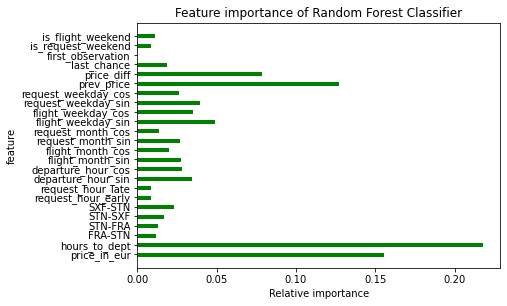

<Figure size 360x360 with 0 Axes>

In [ ]:
plot_feature_importance('Random Forest Classifier', rfc_tuning.best_estimator_)

Wie im Balkendiagramm der Feature Importance zu erkennen ist, haben die Stunden bis zum Abflug (Hours_to_dept), der Preis in €, so wie der vorherige Preis (prev_price) und dessen Differenz (price_diff) das größte Gewicht. Das Wochenende spielt in diesem Modell nur eine geringe Rolle

Die folgende Funktion plottet eine ROC-Kurve.
Die ROC-Kurve zeigt den Trade-off zwischen Sensitivität und Spezifität. 
Steigt die Kurve anfangs von (0.0|0.0) auf (0.0|1.0) an und verläuft dann waagerecht weiter, bis sie (1.0|1.0) erreicht hat, so spricht man von einem perfekten Classifier.

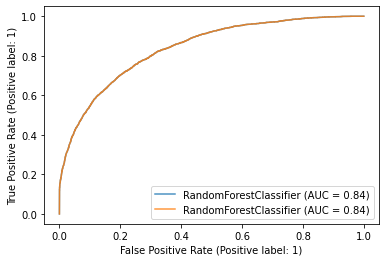

In [ ]:
def plot_roc_auc(estimator):
  ax = plt.gca()
  rfc_disp = plot_roc_curve(estimator, X_test, y_test, ax=ax, alpha=0.8)
  rfc_disp.plot(ax=ax, alpha=0.8)

plot_roc_auc(rfc_random_tuning.best_estimator_)

## Gradient Boosted Trees



Im Gegensatz zum Random Forest fügt Gradient Boost den Baum von Beginn an zusammen und Random Forest erst zum Schluss.
So können mit Gradient Boosted Trees viele schwache Lernalgorithmen zu einem starken Modell vereint werden, da jeder Baum auf den Ergebnissen des vorherigen Baums aufbauen

### Hyperparameter Tuning:

In [ ]:
gbc = GradientBoostingClassifier()

In [ ]:
random_grid = {
    'learning_rate':[1, 0.5, 0.1, 0.05, 0.01], 
    'n_estimators':[300, 400, 500, 600, 700],
    'max_depth':[1, 3, 5, 7, 9],
    'min_samples_split':[0.1, 0.3, 0.5, 0.7, 0.9],
    'min_samples_leaf':[0.1, 0.2, 0.3, 0.4, 0.5]
}

gbc_tuning = RandomizedSearchCV(estimator = gbc,
                            param_distributions = random_grid, 
                            scoring='accuracy', 
                            n_jobs=1,  
                            cv=fold,
                            verbose=2)

In [ ]:
gbc_tuning.fit(X_train, y_train, groups=groups_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=0.1, min_samples_split=0.7, n_estimators=400; total time=  23.2s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=0.1, min_samples_split=0.7, n_estimators=400; total time=  20.4s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=0.1, min_samples_split=0.7, n_estimators=400; total time=  20.2s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=0.1, min_samples_split=0.7, n_estimators=400; total time=  19.0s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=0.1, min_samples_split=0.7, n_estimators=400; total time=  19.4s
[CV] END learning_rate=0.5, max_depth=9, min_samples_leaf=0.3, min_samples_split=0.1, n_estimators=400; total time=  16.2s
[CV] END learning_rate=0.5, max_depth=9, min_samples_leaf=0.3, min_samples_split=0.1, n_estimators=400; total time=  16.2s
[CV] END learning_rate=0.5, max_depth=9, min_samples_leaf=0.3, min_samples_spl

RandomizedSearchCV(cv=GroupShuffleSplit(n_splits=5, random_state=42, test_size=None,
         train_size=None),
                   estimator=GradientBoostingClassifier(), n_jobs=1,
                   param_distributions={'learning_rate': [1, 0.5, 0.1, 0.05,
                                                          0.01],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'min_samples_leaf': [0.1, 0.2, 0.3, 0.4,
                                                             0.5],
                                        'min_samples_split': [0.1, 0.3, 0.5,
                                                              0.7, 0.9],
                                        'n_estimators': [300, 400, 500, 600,
                                                         700]},
                   scoring='accuracy', verbose=2)

### Evaluation:

In [ ]:
print(gbc_tuning.best_params_)
print(gbc_tuning.best_estimator_)
print(gbc_tuning.best_score_)

{'n_estimators': 400, 'min_samples_split': 0.7, 'min_samples_leaf': 0.1, 'max_depth': 3, 'learning_rate': 1}
GradientBoostingClassifier(learning_rate=1, min_samples_leaf=0.1,
                           min_samples_split=0.7, n_estimators=400)
0.8110419440001042


In [ ]:
evaluate(gbc_tuning.best_estimator_, X_test, y_test)

Accuracy: 81.41%
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     13201
           1       0.66      0.31      0.42      3682

    accuracy                           0.81     16883
   macro avg       0.74      0.63      0.66     16883
weighted avg       0.79      0.81      0.79     16883

0 = wait, 1 = buy {0: 15136, 1: 1747}
[[12599   602]
 [ 2537  1145]]


81.40733281999644

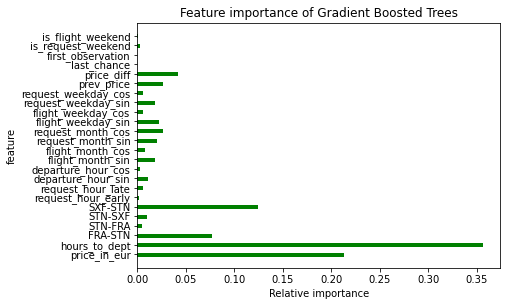

<Figure size 360x360 with 0 Axes>

In [ ]:
plot_feature_importance('Gradient Boosted Trees', gbc_tuning.best_estimator_)

Beim Gradient Boosted Tree hat das Wochenende gar keine Aussagekraft. Dafür haben neben den den Stunden bis zum Abflug und dem Preis in € die Flugrouten SXF-STN und FRA-STN einen hohen Stellenwert

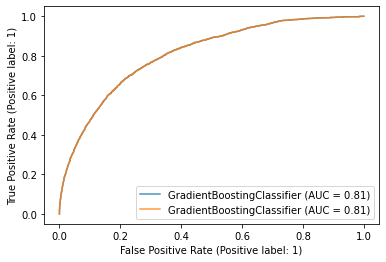

In [ ]:
plot_roc_auc(gbc_tuning.best_estimator_)

##Support Vector Machines:

Eine Support Vector Machine nimmt eine Menge von Trainingsdaten, bei denen bekannt ist, welcher Klasse sie zugehören. 
Jedes Objekt wird durch einen Vektor in einem Vektorraum repräsentiert. Der Raum wird durch eine Hyperebene so aufgeteilt, dass sich zwei Klassen ergeben, denen die Objekte zugeteilt werden.

### Hyperparameter Tuning

In [ ]:
#create model
svc = SVC()

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [10, 1, 0.1, 0.01, 0.001], 'kernel': ['rbf'], 'class_weight': ['balanced']} 
svc_tuning = RandomizedSearchCV(svc, param_grid, cv=fold, refit=True, verbose=2, n_jobs=1)

In [ ]:
svc_tuning.fit(X_train, y_train, groups=groups_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=100, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 4.2min
[CV] END C=100, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 3.9min
[CV] END C=100, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 3.9min
[CV] END C=100, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 3.7min
[CV] END C=100, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 3.5min
[CV] END .C=100, class_weight=balanced, gamma=10, kernel=rbf; total time=14.1min
[CV] END .C=100, class_weight=balanced, gamma=10, kernel=rbf; total time=15.4min
[CV] END .C=100, class_weight=balanced, gamma=10, kernel=rbf; total time=14.7min
[CV] END .C=100, class_weight=balanced, gamma=10, kernel=rbf; total time=14.2min
[CV] END .C=100, class_weight=balanced, gamma=10, kernel=rbf; total time=13.9min
[CV] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 3.7min
[CV] END C=10, class_weight=balanced, gamma

RandomizedSearchCV(cv=GroupShuffleSplit(n_splits=5, random_state=42, test_size=None,
         train_size=None),
                   estimator=SVC(), n_jobs=1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': ['balanced'],
                                        'gamma': [10, 1, 0.1, 0.01, 0.001],
                                        'kernel': ['rbf']},
                   verbose=2)

In [ ]:
print(svc_tuning.best_params_)
print(svc_tuning.best_estimator_)
print("F1: {0: .4f}".format(svc_tuning.best_score_))

{'kernel': 'rbf', 'gamma': 10, 'class_weight': 'balanced', 'C': 100}
SVC(C=100, class_weight='balanced', gamma=10)
F1:  0.7386


### Evaluation

In [ ]:
#evaluate predictions
evaluate(svc_tuning.best_estimator_,X_test,y_test)

Accuracy: 73.36%
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     13201
           1       0.39      0.40      0.39      3682

    accuracy                           0.73     16883
   macro avg       0.61      0.61      0.61     16883
weighted avg       0.74      0.73      0.73     16883

0 = wait, 1 = buy {0: 13138, 1: 3745}
[[10921  2280]
 [ 2217  1465]]


73.36373867203696

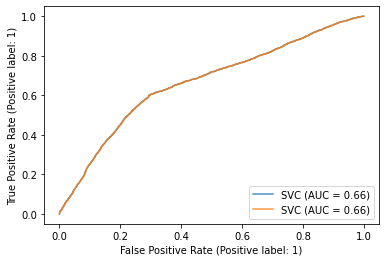

In [ ]:
plot_roc_auc(svc_tuning.best_estimator_)

Ein C von 1000 dauerte zu lang im GridSearch über 5 folds. Vielleicht können wir das Ergebnis durch ein erhöhen von C jedoch verbessern:

In [ ]:
svc_test = SVC(C=1000, class_weight='balanced', gamma=10)
svc_test.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced', gamma=10)

In [ ]:
evaluate(svc_test,X_test,y_test)

Accuracy: 73.80%
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     13201
           1       0.39      0.36      0.38      3682

    accuracy                           0.74     16883
   macro avg       0.61      0.60      0.61     16883
weighted avg       0.73      0.74      0.73     16883

0 = wait, 1 = buy {0: 13462, 1: 3421}
[[11120  2081]
 [ 2342  1340]]


73.80204939880353

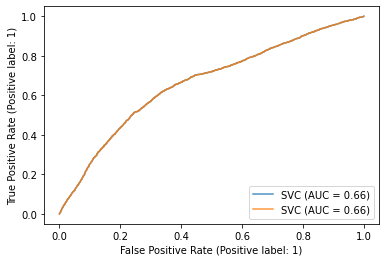

In [ ]:
plot_roc_auc(svc_test)

## Naive Bayes: 

In [ ]:
#set models to be used for naive bayes
gnb, mnb, conb, bnb = GaussianNB(), MultinomialNB(), ComplementNB(), BernoulliNB()
models_nb = [gnb, mnb, conb, bnb]

In [ ]:
#fit model and evalute the predictions
for model in models_nb:
  print('-----------------------------------------------------')
  acc = 0
  for train_ix, test_ix in fold.split(X, y, groups):

    X_train_nb, X_test_nb = X[train_ix], X[test_ix]
    y_train_nb, y_test_nb = np.take(y, train_ix), np.take(y, test_ix)

    model.fit(X_train_nb, y_train_nb)

    acc += evaluate(model, X_test_nb, y_test_nb)

  print(f'Mean Accuracy: {acc/5}')
  # Gaussian Naive Bayes: 74.2

-----------------------------------------------------
Accuracy: 79.36%
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     13201
           1       0.96      0.06      0.11      3682

    accuracy                           0.79     16883
   macro avg       0.88      0.53      0.49     16883
weighted avg       0.83      0.79      0.71     16883

0 = wait, 1 = buy {0: 16669, 1: 214}
[[13193     8]
 [ 3476   206]]
Accuracy: 79.20%
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     13189
           1       0.99      0.06      0.11      3723

    accuracy                           0.79     16912
   macro avg       0.89      0.53      0.49     16912
weighted avg       0.83      0.79      0.71     16912

0 = wait, 1 = buy {0: 16701, 1: 211}
[[13186     3]
 [ 3515   208]]
Accuracy: 78.17%
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     12

In [ ]:
#best Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
evaluate(mnb, X_test, y_test)

Accuracy: 79.39%
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     13201
           1       1.00      0.05      0.10      3682

    accuracy                           0.79     16883
   macro avg       0.90      0.53      0.49     16883
weighted avg       0.84      0.79      0.71     16883

0 = wait, 1 = buy {0: 16681, 1: 202}
[[13201     0]
 [ 3480   202]]


79.38754960611266

# Testdata: 

Hier werden die Feautures, die in den Trainingsdaten verwendet wurden, den Testdaten hinzugefügt.

In [ ]:
gdown.download('https://drive.google.com/uc?id=108jgQ1YCBDcVScJdohWlMMjGzcEqmD58', output='test_set.csv', quiet=True)

'test_set.csv'

In [ ]:
# set data types
dtypes = {'Request_Date':'str', 'Flight_Date':'str', 'Departure_hour':'int', 'flight_unique_id':'str', 'route_abb':'str', 'Price_In_Eur':'float'}
parse_dates = ['Request_Date', 'Flight_Date']
# import csv
df_test = pd.read_csv('test_set.csv',index_col=0, dtype=dtypes,parse_dates=parse_dates)
# lower case column names
df_test.columns = map(str.lower, df_test.columns)
df_test["departure_hour_timezone"] = 'T' + df_test['departure_hour'].astype(str) + ':00:00Z'
df_test


,request_date,flight_date,departure_hour,flight_unique_id,route_abb,price_in_eur,departure_hour_timezone
index,,,,,,,
1,2019-06-03 11:00:00+00:00,2019-07-02,7,2019-07-02 FR 145,STN-SXF,30.32,T7:00:00Z
2,2019-06-03 23:00:00+00:00,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.53,T7:00:00Z
3,2019-06-04 11:00:00+00:00,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.47,T7:00:00Z
4,2019-06-04 23:00:00+00:00,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.47,T7:00:00Z
5,2019-06-05 11:00:00+00:00,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.52,T7:00:00Z
...,...,...,...,...,...,...,...
5579,2019-07-30 23:00:00+00:00,2019-08-02,22,2019-08-02 FR 8545,SXF-STN,42.83,T22:00:00Z
5580,2019-07-31 11:00:00+00:00,2019-08-02,22,2019-08-02 FR 8545,SXF-STN,50.99,T22:00:00Z
5581,2019-07-31 23:00:00+00:00,2019-08-02,22,2019-08-02 FR 8545,SXF-STN,50.99,T22:00:00Z


In [ ]:
# add time related features
df_test['request_hour'] = df_test['request_date'].apply(lambda date:date.hour)
df_test['flight_date'] = df_test['flight_date'].astype(str) + df_test['departure_hour_timezone'].astype(str)
df_test.request_date=pd.to_datetime(df_test.request_date)
df_test.flight_date=pd.to_datetime(df_test.flight_date)
df_test['flight_month'] = df_test['flight_date'].apply(lambda date:date.month)
df_test["request_month"] = df_test['request_date'].apply(lambda date:date.month)
df_test['flight_weekday'] = df_test['flight_date'].apply(lambda date:date.weekday())
df_test['request_weekday'] = df_test['request_date'].apply(lambda date:date.weekday())
df_test['hours_to_dept'] = (df_test['flight_date'] - df_test['request_date'])
df_test['hours_to_dept'] = df_test['hours_to_dept'].apply(lambda x: int(divmod(x.total_seconds(), 3600)[0]))

In [ ]:
df_test

,request_date,flight_date,departure_hour,flight_unique_id,route_abb,price_in_eur,departure_hour_timezone,request_hour,flight_month,request_month,flight_weekday,request_weekday,hours_to_dept
index,,,,,,,,,,,,,
1,2019-06-03 11:00:00+00:00,2019-07-02 07:00:00+00:00,7,2019-07-02 FR 145,STN-SXF,30.32,T7:00:00Z,11,7,6,1,0,692
2,2019-06-03 23:00:00+00:00,2019-07-02 07:00:00+00:00,7,2019-07-02 FR 145,STN-SXF,44.53,T7:00:00Z,23,7,6,1,0,680
3,2019-06-04 11:00:00+00:00,2019-07-02 07:00:00+00:00,7,2019-07-02 FR 145,STN-SXF,44.47,T7:00:00Z,11,7,6,1,1,668
4,2019-06-04 23:00:00+00:00,2019-07-02 07:00:00+00:00,7,2019-07-02 FR 145,STN-SXF,44.47,T7:00:00Z,23,7,6,1,1,656
5,2019-06-05 11:00:00+00:00,2019-07-02 07:00:00+00:00,7,2019-07-02 FR 145,STN-SXF,44.52,T7:00:00Z,11,7,6,1,2,644
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,2019-07-30 23:00:00+00:00,2019-08-02 22:00:00+00:00,22,2019-08-02 FR 8545,SXF-STN,42.83,T22:00:00Z,23,8,7,4,1,71
5580,2019-07-31 11:00:00+00:00,2019-08-02 22:00:00+00:00,22,2019-08-02 FR 8545,SXF-STN,50.99,T22:00:00Z,11,8,7,4,2,59
5581,2019-07-31 23:00:00+00:00,2019-08-02 22:00:00+00:00,22,2019-08-02 FR 8545,SXF-STN,50.99,T22:00:00Z,23,8,7,4,2,47


In [ ]:
# one hot encode route_abb
df_test = pd.concat([df_test, pd.get_dummies(df_test['route_abb'])], axis=1)

In [ ]:
# one hot encode request_hour
df_test['request_hour_early'] = df_test['request_hour'].apply(lambda x: 1 if x==11 else 0)
df_test['request_hour_late'] = df_test['request_hour'].apply(lambda x: 1 if x==23 else 0)

In [ ]:
# weekdays, month and departure_hour has to be transformed as they are cyclical features (e.g. 23h and 0h are extremely close to each other)
# http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

df_test['departure_hour_sin'] = np.sin(df_test.departure_hour*(2.*np.pi/24))
df_test['departure_hour_cos'] = np.cos(df_test.departure_hour*(2.*np.pi/24))

df_test['flight_month_sin'] = np.sin((df_test.flight_month-1)*(2.*np.pi/12))
df_test['flight_month_cos'] = np.cos((df_test.flight_month-1)*(2.*np.pi/12))

df_test['request_month_sin'] = np.sin((df_test.request_month-1)*(2.*np.pi/12))
df_test['request_month_cos'] = np.cos((df_test.request_month-1)*(2.*np.pi/12))

df_test['flight_weekday_sin'] = np.sin(df_test.flight_weekday*(2.*np.pi/7))
df_test['flight_weekday_cos'] = np.cos(df_test.flight_weekday*(2.*np.pi/7))

df_test['request_weekday_sin'] = np.sin(df_test.request_weekday*(2.*np.pi/7))
df_test['request_weekday_cos'] = np.cos(df_test.request_weekday*(2.*np.pi/7))

In [ ]:
unique_ids = df_test['flight_unique_id'].unique()
df_price_augment = pd.DataFrame()
for id in unique_ids:
    group_df = df_test.loc[df_test['flight_unique_id'] == id].copy()

    price_list = group_df['price_in_eur'].to_list()
    insert = price_list[0]
    price_list.insert(0, insert)
    del price_list[-1]
    group_df['prev_price'] = price_list

    group_df['price_diff'] = group_df['price_in_eur'].sub(group_df['prev_price'], fill_value=0)

    temp_list = [0 for x in range(len(group_df))]
    temp_list.insert(len(temp_list), 1)
    del temp_list[0]
    group_df['last_chance'] = temp_list
    
    df_price_augment = pd.concat([df_price_augment, group_df], ignore_index=True)

df_price_augment['first_observation'] = df_price_augment['prev_price'].apply(lambda x: 1 if x == 0.00 else 0)

df_test = df_price_augment

In [ ]:
#create feature is_request_weekend to check if the request date is at the weekend
temp_list = []
for index, row in df_test.iterrows():
  if (row["request_weekday"]==5)|(row["request_weekday"]==6):
    temp_list.append(1)
  else:
    temp_list.append(0)

print(temp_list)
df_test["is_request_weekend"] = temp_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
#create feature is_flight_weekend to check if the request date is at the weekend
temp_list = []
for index, row in df_test.iterrows():
  if (row["flight_weekday"]==5)|(row["flight_weekday"]==6):
    temp_list.append(1)
  else:
    temp_list.append(0)

print(temp_list)
df_test["is_flight_weekend"] = temp_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
df_test_features = df_test.drop('flight_unique_id request_date flight_date route_abb request_hour departure_hour flight_month request_month flight_weekday request_weekday departure_hour_timezone'.split(), axis=1)

In [ ]:
df_test_features

,price_in_eur,hours_to_dept,FRA-STN,STN-FRA,STN-SXF,SXF-STN,request_hour_early,request_hour_late,departure_hour_sin,departure_hour_cos,flight_month_sin,flight_month_cos,request_month_sin,request_month_cos,flight_weekday_sin,flight_weekday_cos,request_weekday_sin,request_weekday_cos,prev_price,price_diff,last_chance,first_observation,is_request_weekend,is_flight_weekend
0,30.32,692,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,0.00,0,0,0,0
1,44.53,680,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,14.21,0,0,0,0
2,44.47,668,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.53,-0.06,0,0,0,0
3,44.47,656,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.47,0.00,0,0,0,0
4,44.52,644,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.974928,-0.222521,44.47,0.05,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,42.83,71,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.781831,0.623490,42.83,0.00,0,0,0,0
5579,50.99,59,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,42.83,8.16,0,0,0,0
5580,50.99,47,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,50.99,0.00,0,0,0,0
5581,50.99,35,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.433884,-0.900969,50.99,0.00,0,0,0,0


In [ ]:
X_test = df_test_features
X_test = scaler.fit_transform(X_test)

#Vorhersagen:

In [ ]:
#get predictions for comparison
prediction_rfc = rfc_tuning.best_estimator_.predict(X_test)
prediction_gbc = gbc_tuning.best_estimator_.predict(X_test)
prediction_svc = svc_tuning.best_estimator_.predict(X_test)
predictions_nb = mnb.predict(X_test)

In [ ]:
#set prediction probabilities
pred_prob_rfc = rfc_tuning.best_estimator_.predict_proba(X_test)
pred_prob_gbc = gbc_tuning.best_estimator_.predict_proba(X_test)
#pred_prob_svc = svc_tuning.best_estimator_.predict_proba(X_test)
pred_prob_nb = mnb.predict_proba(X_test)

In [ ]:
#adding new columns with the results for buy and the probabilites 
#of the predictions of the different models to df_test_features data frame
df_test_features[["buy_rfc"]] = prediction_rfc
df_test_features[["buy_gbc"]] = prediction_gbc
df_test_features[["buy_svc"]] = prediction_svc
df_test_features[["buy_nb"]] = predictions_nb

df_test_features[['waitProbRfc','buyProbRfc']] = pred_prob_rfc
df_test_features[['waitProbGbc','buyProbGbc']] = pred_prob_gbc
#df_test_features[['waitProbSvc','buyProbSvc']] = pred_prob_svc
df_test_features[['waitProbNb','buyProbNb']] = pred_prob_nb
df_test_features

,price_in_eur,hours_to_dept,FRA-STN,STN-FRA,STN-SXF,SXF-STN,request_hour_early,request_hour_late,departure_hour_sin,departure_hour_cos,flight_month_sin,flight_month_cos,request_month_sin,request_month_cos,flight_weekday_sin,flight_weekday_cos,request_weekday_sin,request_weekday_cos,prev_price,price_diff,last_chance,first_observation,is_request_weekend,is_flight_weekend,buy_rfc,buy_gbc,buy_svc,buy_nb,waitProbRfc,buyProbRfc,waitProbGbc,buyProbGbc,waitProbNb,buyProbNb
0,30.32,692,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,0.00,0,0,0,0,0,0,0,0,0.636067,0.363933,0.928902,0.071098,0.836855,0.163145
1,44.53,680,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,14.21,0,0,0,0,0,0,0,0,0.889930,0.110070,0.976732,0.023268,0.848095,0.151905
2,44.47,668,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.53,-0.06,0,0,0,0,0,0,0,0,0.784265,0.215735,0.945745,0.054255,0.835616,0.164384
3,44.47,656,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.47,0.00,0,0,0,0,0,0,0,0,0.856352,0.143648,0.950402,0.049598,0.846584,0.153416
4,44.52,644,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.974928,-0.222521,44.47,0.05,0,0,0,0,0,0,0,0,0.750327,0.249673,0.951007,0.048993,0.830715,0.169285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,42.83,71,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.781831,0.623490,42.83,0.00,0,0,0,0,1,1,1,0,0.266137,0.733863,0.085558,0.914442,0.728792,0.271208
5579,50.99,59,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,42.83,8.16,0,0,0,0,1,1,1,0,0.368031,0.631969,0.084048,0.915952,0.705297,0.294703
5580,50.99,47,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,50.99,0.00,0,0,0,0,1,1,1,0,0.354900,0.645100,0.089351,0.910649,0.722195,0.277805
5581,50.99,35,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.433884,-0.900969,50.99,0.00,0,0,0,0,1,1,0,0,0.387578,0.612422,0.029537,0.970463,0.690806,0.309194


In [ ]:
df_test_features["flight_unique_id"] = df_test['flight_unique_id']
df_test_features["request_date"] = df_test['request_date']

In [ ]:
def check_buy(buy_x):
    #check if buy = 1 for last possible date to buy a flight
    buy_1=0
    buy_0=0
    for id in np.unique(df_test_features.flight_unique_id):
        flight_subset = df_test_features[(df_test_features.flight_unique_id == id)]
        last_buy = flight_subset[buy_x][flight_subset.request_date == max(flight_subset.request_date)]
        if last_buy.iloc[0] >= 0.5:
            buy_1=buy_1+1
        else:
            buy_0=buy_0+1

    print("gekauft am letzten Tag:",buy_1)
    print("nicht gekauft am letzten Tag:",buy_0)

In [ ]:
check_buy('buy_rfc')
check_buy('buy_gbc')
check_buy('buy_svc')
check_buy('buy_nb')

gekauft am letzten Tag: 65
nicht gekauft am letzten Tag: 0
gekauft am letzten Tag: 9
nicht gekauft am letzten Tag: 56
gekauft am letzten Tag: 0
nicht gekauft am letzten Tag: 65
gekauft am letzten Tag: 65
nicht gekauft am letzten Tag: 0


Wie in den Ergebnissen von check_buy zu sehen ist, werden bei Random Forest  und Naive Bayes alle Flüge am letzten möglichen Datum gekauft.

#Vergleich der Modelle:

Vergleiche die Ergebnisse der Modelle auf gesamte Gleichheit, Gleichheit von Kaufen und Gleichheit von warten.

In [ ]:
#compare same results between 2 models
def compare(df_test_features, model1, model2):
  resultCompare = []
  for index, row in  df_test_features.iterrows():
    df_test_features.iloc[index] = row
    resultCompare.append(row[model1] == row[model2])
  return resultCompare     

In [ ]:
#get absolute and relative numbers of same and different values
def compareCounts(df_test_features,models):
  print(df_test_features[models].value_counts())
  print(df_test_features[models].value_counts(normalize=True))

In [ ]:
df_test_features["result_gbcrfc"] = compare(df_test_features,'buy_gbc','buy_rfc')
df_test_features["result_gbcsvc"] = compare(df_test_features,'buy_gbc','buy_svc')
df_test_features["result_gbcnb"] = compare(df_test_features,'buy_gbc','buy_nb')
df_test_features["result_rfcsvc"] = compare(df_test_features,'buy_svc','buy_rfc')
df_test_features["result_rfcnb"] = compare(df_test_features,'buy_nb','buy_rfc')
df_test_features["result_svcnb"] = compare(df_test_features,'buy_svc','buy_nb')
df_test_features

,price_in_eur,hours_to_dept,FRA-STN,STN-FRA,STN-SXF,SXF-STN,request_hour_early,request_hour_late,departure_hour_sin,departure_hour_cos,flight_month_sin,flight_month_cos,request_month_sin,request_month_cos,flight_weekday_sin,flight_weekday_cos,request_weekday_sin,request_weekday_cos,prev_price,price_diff,last_chance,first_observation,is_request_weekend,is_flight_weekend,buy_rfc,buy_gbc,buy_svc,buy_nb,waitProbRfc,buyProbRfc,waitProbGbc,buyProbGbc,waitProbNb,buyProbNb,flight_unique_id,request_date,result_gbcrfc,result_gbcsvc,result_gbcnb,result_rfcsvc,result_rfcnb,result_svcnb
0,30.32,692,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,0.00,0,0,0,0,0,0,0,0,0.636067,0.363933,0.928902,0.071098,0.836855,0.163145,2019-07-02 FR 145,2019-06-03 11:00:00+00:00,True,True,True,True,True,True
1,44.53,680,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,14.21,0,0,0,0,0,0,0,0,0.889930,0.110070,0.976732,0.023268,0.848095,0.151905,2019-07-02 FR 145,2019-06-03 23:00:00+00:00,True,True,True,True,True,True
2,44.47,668,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.53,-0.06,0,0,0,0,0,0,0,0,0.784265,0.215735,0.945745,0.054255,0.835616,0.164384,2019-07-02 FR 145,2019-06-04 11:00:00+00:00,True,True,True,True,True,True
3,44.47,656,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.47,0.00,0,0,0,0,0,0,0,0,0.856352,0.143648,0.950402,0.049598,0.846584,0.153416,2019-07-02 FR 145,2019-06-04 23:00:00+00:00,True,True,True,True,True,True
4,44.52,644,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.974928,-0.222521,44.47,0.05,0,0,0,0,0,0,0,0,0.750327,0.249673,0.951007,0.048993,0.830715,0.169285,2019-07-02 FR 145,2019-06-05 11:00:00+00:00,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,42.83,71,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.781831,0.623490,42.83,0.00,0,0,0,0,1,1,1,0,0.266137,0.733863,0.085558,0.914442,0.728792,0.271208,2019-08-02 FR 8545,2019-07-30 23:00:00+00:00,True,True,False,True,False,False
5579,50.99,59,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,42.83,8.16,0,0,0,0,1,1,1,0,0.368031,0.631969,0.084048,0.915952,0.705297,0.294703,2019-08-02 FR 8545,2019-07-31 11:00:00+00:00,True,True,False,True,False,False
5580,50.99,47,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,50.99,0.00,0,0,0,0,1,1,1,0,0.354900,0.645100,0.089351,0.910649,0.722195,0.277805,2019-08-02 FR 8545,2019-07-31 23:00:00+00:00,True,True,False,True,False,False
5581,50.99,35,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.433884,-0.900969,50.99,0.00,0,0,0,0,1,1,0,0,0.387578,0.612422,0.029537,0.970463,0.690806,0.309194,2019-08-02 FR 8545,2019-08-01 11:00:00+00:00,True,False,False,False,False,True


In [ ]:
compareCounts(df_test_features,"result_gbcrfc")
compareCounts(df_test_features,"result_gbcsvc")
compareCounts(df_test_features,"result_gbcnb")
compareCounts(df_test_features,"result_rfcsvc")
compareCounts(df_test_features,"result_rfcnb")
compareCounts(df_test_features,"result_svcnb")

True     5324
False     259
Name: result_gbcrfc, dtype: int64
True     0.953609
False    0.046391
Name: result_gbcrfc, dtype: float64
True     5238
False     345
Name: result_gbcsvc, dtype: int64
True     0.938205
False    0.061795
Name: result_gbcsvc, dtype: float64
True     5254
False     329
Name: result_gbcnb, dtype: int64
True     0.941071
False    0.058929
Name: result_gbcnb, dtype: float64
True     5211
False     372
Name: result_rfcsvc, dtype: int64
True     0.933369
False    0.066631
Name: result_rfcsvc, dtype: float64
True     5401
False     182
Name: result_rfcnb, dtype: int64
True     0.967401
False    0.032599
Name: result_rfcnb, dtype: float64
True     5313
False     270
Name: result_svcnb, dtype: int64
True     0.951639
False    0.048361
Name: result_svcnb, dtype: float64


Wie in den Ergebnissen zu erkennen ist, stimmen bei allen verglichenen Modellen mehr als 90% der Werte miteinander überein

In [ ]:
#compare same results between 2 models
def compareBuy(df_test_features, model1, model2):
  resultCompare = []
  for index, row in  df_test_features.iterrows():
    df_test_features.iloc[index] = row
    resultCompare.append(row[model1] == 1 and row[model2] == 1)
  return resultCompare  

In [ ]:
df_test_features["resultBuy_gbcrfc"] = compareBuy(df_test_features,'buy_gbc','buy_rfc')
df_test_features["resultBuy_gbcsvc"] = compareBuy(df_test_features,'buy_gbc','buy_svc')
df_test_features["resultBuy_gbcnb"] = compareBuy(df_test_features,'buy_gbc','buy_nb')
df_test_features["resultBuy_rfcsvc"] = compareBuy(df_test_features,'buy_svc','buy_rfc')
df_test_features["resultBuy_rfcnb"] = compareBuy(df_test_features,'buy_nb','buy_rfc')
df_test_features["resultBuy_svcnb"] = compareBuy(df_test_features,'buy_svc','buy_nb')
df_test_features

,price_in_eur,hours_to_dept,FRA-STN,STN-FRA,STN-SXF,SXF-STN,request_hour_early,request_hour_late,departure_hour_sin,departure_hour_cos,flight_month_sin,flight_month_cos,request_month_sin,request_month_cos,flight_weekday_sin,flight_weekday_cos,request_weekday_sin,request_weekday_cos,prev_price,price_diff,last_chance,first_observation,is_request_weekend,is_flight_weekend,buy_rfc,buy_gbc,buy_svc,buy_nb,waitProbRfc,buyProbRfc,waitProbGbc,buyProbGbc,waitProbNb,buyProbNb,flight_unique_id,request_date,result_gbcrfc,result_gbcsvc,result_gbcnb,result_rfcsvc,result_rfcnb,result_svcnb,resultBuy_gbcrfc,resultBuy_gbcsvc,resultBuy_gbcnb,resultBuy_rfcsvc,resultBuy_rfcnb,resultBuy_svcnb
0,30.32,692,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,0.00,0,0,0,0,0,0,0,0,0.636067,0.363933,0.928902,0.071098,0.836855,0.163145,2019-07-02 FR 145,2019-06-03 11:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False
1,44.53,680,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,14.21,0,0,0,0,0,0,0,0,0.889930,0.110070,0.976732,0.023268,0.848095,0.151905,2019-07-02 FR 145,2019-06-03 23:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False
2,44.47,668,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.53,-0.06,0,0,0,0,0,0,0,0,0.784265,0.215735,0.945745,0.054255,0.835616,0.164384,2019-07-02 FR 145,2019-06-04 11:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False
3,44.47,656,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.47,0.00,0,0,0,0,0,0,0,0,0.856352,0.143648,0.950402,0.049598,0.846584,0.153416,2019-07-02 FR 145,2019-06-04 23:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False
4,44.52,644,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.974928,-0.222521,44.47,0.05,0,0,0,0,0,0,0,0,0.750327,0.249673,0.951007,0.048993,0.830715,0.169285,2019-07-02 FR 145,2019-06-05 11:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,42.83,71,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.781831,0.623490,42.83,0.00,0,0,0,0,1,1,1,0,0.266137,0.733863,0.085558,0.914442,0.728792,0.271208,2019-08-02 FR 8545,2019-07-30 23:00:00+00:00,True,True,False,True,False,False,True,True,False,True,False,False
5579,50.99,59,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,42.83,8.16,0,0,0,0,1,1,1,0,0.368031,0.631969,0.084048,0.915952,0.705297,0.294703,2019-08-02 FR 8545,2019-07-31 11:00:00+00:00,True,True,False,True,False,False,True,True,False,True,False,False
5580,50.99,47,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,50.99,0.00,0,0,0,0,1,1,1,0,0.354900,0.645100,0.089351,0.910649,0.722195,0.277805,2019-08-02 FR 8545,2019-07-31 23:00:00+00:00,True,True,False,True,False,False,True,True,False,True,False,False
5581,50.99,35,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.433884,-0.900969,50.99,0.00,0,0,0,0,1,1,0,0,0.387578,0.612422,0.029537,0.970463,0.690806,0.309194,2019-08-02 FR 8545,2019-08-01 11:00:00+00:00,True,False,False,False,False,True,True,False,False,False,False,False


In [ ]:
compareCounts(df_test_features,"resultBuy_gbcrfc")
compareCounts(df_test_features,"resultBuy_gbcsvc")
compareCounts(df_test_features,"resultBuy_gbcnb")
compareCounts(df_test_features,"resultBuy_rfcsvc")
compareCounts(df_test_features,"resultBuy_rfcnb")
compareCounts(df_test_features,"resultBuy_svcnb")

False    5448
True      135
Name: resultBuy_gbcrfc, dtype: int64
False    0.975819
True     0.024181
Name: resultBuy_gbcrfc, dtype: float64
False    5512
True       71
Name: resultBuy_gbcsvc, dtype: int64
False    0.987283
True     0.012717
Name: resultBuy_gbcsvc, dtype: float64
False    5574
True        9
Name: resultBuy_gbcnb, dtype: int64
False    0.998388
True     0.001612
Name: resultBuy_gbcnb, dtype: float64
False    5543
True       40
Name: resultBuy_rfcsvc, dtype: int64
False    0.992835
True     0.007165
Name: resultBuy_rfcsvc, dtype: float64
False    5518
True       65
Name: resultBuy_rfcnb, dtype: int64
False    0.988358
True     0.011642
Name: resultBuy_rfcnb, dtype: float64
False    5583
Name: resultBuy_svcnb, dtype: int64
False    1.0
Name: resultBuy_svcnb, dtype: float64


Wie in den Ergebnissen zu erkennen ist, stimmen bei allen verglichenen Modellen mehr als 90% der Buy-Werte nicht überein

In [ ]:
#compare same results for wait between 2 models
def compareWait(df_test_features, model1, model2):
  resultCompare = []
  for index, row in  df_test_features.iterrows():
    df_test_features.iloc[index] = row
    resultCompare.append(row[model1] == 0 and row[model2] == 0)
  return resultCompare

In [ ]:
df_test_features["resultWait_gbcrfc"] =compareWait(df_test_features,'buy_gbc','buy_rfc')
df_test_features["resultWait_gbcsvc"] = compareWait(df_test_features,'buy_gbc','buy_svc')
df_test_features["resultWait_gbcnb"] = compareWait(df_test_features,'buy_gbc','buy_nb')
df_test_features["resultWait_rfcsvc"] =compareWait(df_test_features,'buy_svc','buy_rfc')
df_test_features["resultWait_rfcnb"] = compareWait(df_test_features,'buy_nb','buy_rfc')
df_test_features["resultWait_svcnb"] = compareWait(df_test_features,'buy_svc','buy_nb')
df_test_features

,price_in_eur,hours_to_dept,FRA-STN,STN-FRA,STN-SXF,SXF-STN,request_hour_early,request_hour_late,departure_hour_sin,departure_hour_cos,flight_month_sin,flight_month_cos,request_month_sin,request_month_cos,flight_weekday_sin,flight_weekday_cos,request_weekday_sin,request_weekday_cos,prev_price,price_diff,last_chance,first_observation,is_request_weekend,is_flight_weekend,buy_rfc,buy_gbc,buy_svc,buy_nb,waitProbRfc,buyProbRfc,waitProbGbc,buyProbGbc,waitProbNb,buyProbNb,flight_unique_id,request_date,result_gbcrfc,result_gbcsvc,result_gbcnb,result_rfcsvc,result_rfcnb,result_svcnb,resultBuy_gbcrfc,resultBuy_gbcsvc,resultBuy_gbcnb,resultBuy_rfcsvc,resultBuy_rfcnb,resultBuy_svcnb,resultWait_gbcrfc,resultWait_gbcsvc,resultWait_gbcnb,resultWait_rfcsvc,resultWait_rfcnb,resultWait_svcnb
0,30.32,692,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,0.00,0,0,0,0,0,0,0,0,0.636067,0.363933,0.928902,0.071098,0.836855,0.163145,2019-07-02 FR 145,2019-06-03 11:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
1,44.53,680,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.000000,1.000000,30.32,14.21,0,0,0,0,0,0,0,0,0.889930,0.110070,0.976732,0.023268,0.848095,0.151905,2019-07-02 FR 145,2019-06-03 23:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
2,44.47,668,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.53,-0.06,0,0,0,0,0,0,0,0,0.784265,0.215735,0.945745,0.054255,0.835616,0.164384,2019-07-02 FR 145,2019-06-04 11:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
3,44.47,656,0,0,1,0,0,1,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.781831,0.623490,44.47,0.00,0,0,0,0,0,0,0,0,0.856352,0.143648,0.950402,0.049598,0.846584,0.153416,2019-07-02 FR 145,2019-06-04 23:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
4,44.52,644,0,0,1,0,1,0,0.965926,-0.258819,1.224647e-16,-1.000000,5.000000e-01,-0.866025,0.781831,0.623490,0.974928,-0.222521,44.47,0.05,0,0,0,0,0,0,0,0,0.750327,0.249673,0.951007,0.048993,0.830715,0.169285,2019-07-02 FR 145,2019-06-05 11:00:00+00:00,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,42.83,71,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.781831,0.623490,42.83,0.00,0,0,0,0,1,1,1,0,0.266137,0.733863,0.085558,0.914442,0.728792,0.271208,2019-08-02 FR 8545,2019-07-30 23:00:00+00:00,True,True,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False
5579,50.99,59,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,42.83,8.16,0,0,0,0,1,1,1,0,0.368031,0.631969,0.084048,0.915952,0.705297,0.294703,2019-08-02 FR 8545,2019-07-31 11:00:00+00:00,True,True,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False
5580,50.99,47,0,0,0,1,0,1,-0.500000,0.866025,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-0.433884,-0.900969,0.974928,-0.222521,50.99,0.00,0,0,0,0,1,1,1,0,0.354900,0.645100,0.089351,0.910649,0.722195,0.277805,2019-08-02 FR 8545,2019-07-31 23:00:00+00:00,True,True,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False
5581,50.99,35,0,0,0,1,1,0,-0.500000,0.866025,-5.000000e-01,-0.866025,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.433884,-0.900969,50.99,0.00,0,0,0,0,1,1,0,0,0.387578,0.612422,0.029537,

In [ ]:
compareCounts(df_test_features,"resultWait_gbcrfc")
compareCounts(df_test_features,"resultWait_gbcsvc")
compareCounts(df_test_features,"resultWait_gbcnb")
compareCounts(df_test_features,"resultWait_rfcsvc")
compareCounts(df_test_features,"resultWait_rfcnb")
compareCounts(df_test_features,"resultWait_svcnb")

True     5189
False     394
Name: resultWait_gbcrfc, dtype: int64
True     0.929429
False    0.070571
Name: resultWait_gbcrfc, dtype: float64
True     5167
False     416
Name: resultWait_gbcsvc, dtype: int64
True     0.925488
False    0.074512
Name: resultWait_gbcsvc, dtype: float64
True     5245
False     338
Name: resultWait_gbcnb, dtype: int64
True     0.939459
False    0.060541
Name: resultWait_gbcnb, dtype: float64
True     5171
False     412
Name: resultWait_rfcsvc, dtype: int64
True     0.926205
False    0.073795
Name: resultWait_rfcsvc, dtype: float64
True     5336
False     247
Name: resultWait_rfcnb, dtype: int64
True     0.955759
False    0.044241
Name: resultWait_rfcnb, dtype: float64
True     5313
False     270
Name: resultWait_svcnb, dtype: int64
True     0.951639
False    0.048361
Name: resultWait_svcnb, dtype: float64


Wie in den Ergebnissen zu erkennen ist, stimmen bei allen verglichenen Modellen mehr 90% der Wait-Werte miteinander überein

#Gütemaß:

Anwendung des vorgegebenen Gütemaßes auf die jeweiligen Modellergebnisse

In [ ]:
def model_quality_balance(buy_x, data, threshold = 0.5):
  
  sum_balances = 0
  for id in np.unique(data.flight_unique_id):
    flight_subset = data[(data.flight_unique_id == id)]
    ####hier bin ich stehen geblieben#####
    last_buying_price = flight_subset.price_in_eur[flight_subset.request_date == max(flight_subset.request_date)]
    #print("log" , last_buying_price, id)
    # remaining dates, since the last req. date is always 0
    rem_dates = flight_subset.request_date[flight_subset.request_date != max(flight_subset.request_date)]
    for d in rem_dates.sort_values(ascending = False):
      current = flight_subset[(flight_subset.flight_unique_id == id) & (flight_subset.request_date == d)]
      if current[buy_x].values[0] >= threshold:
        last_buying_price = current.price_in_eur
        #print('new last buying price=' , last_buying_price)
        #print(id, ' - ', d, ': Bought (new last price = ', last_buying_price, ')')
      else:
        balance = current["price_in_eur"].iloc[0] - last_buying_price.iloc[0]
        sum_balances = sum_balances + balance
        #print("balance:",balance)
        #print(id, ' - ', d, ': Waited (Dif = ', balance, ')')
      
  print("Summe: " ,sum_balances)

In [ ]:
model_quality_balance('buy_rfc', df_test_features, threshold=0.5)

Summe:  -371523.2499999989


In [ ]:
model_quality_balance('buy_gbc', df_test_features, threshold=0.5)

Summe:  -349766.3899999991


In [ ]:
model_quality_balance('buy_svc', df_test_features, threshold=0.5)

Summe:  -302395.54999999865


In [ ]:
model_quality_balance('buy_nb', df_test_features, threshold=0.5)

Summe:  -496863.8899999963



Random Forest Classifier ~ (-360.000)

Gradient Boost Classifier: ~ (-350.000)

Support Vector Machine: ~ (-302.000)

Naive Bayes: ~ (-497.000) 

Bei Auswertung des Gütemaßes erkennt man, dass von den Decision Tree Classifiern der Gradient Boost Classifier besser abschneidet. Obwohl der Support Vector Classifier mit ca. 73% die schlechteste Accuracy aller Modelle besitzt, schneidet dieser im Gütemaß am besten ab. 
Auffällig hierbei ist, dass die false negative und true positive ähnlich wie bei den anderen Modellen abschneiden, jedoch die true negative vergleichsweise niedrig ausfallen und die false positve größer sind als die true positives.

Falsche Kaufwerte (false positive) scheinen sich also geringer auf das Gütemaß auszuwirken als Warten-Werte.


#Test des Models mit den niedrigsten false negatives:

In [ ]:
#set models to be used for naive bayes
conb = ComplementNB()
#fit model and evalute the predictions
fold_nb = GroupShuffleSplit(n_splits=5, random_state=42)
print('-----------------------------------------------------')
acc = 0
for train_ix, test_ix in fold_nb.split(X, y, groups):

    X_train_nb, X_test_nb = X[train_ix], X[test_ix]
    y_train_nb, y_test_nb = np.take(y, train_ix), np.take(y, test_ix)

    conb.fit(X_train_nb, y_train_nb)

    acc += evaluate(conb, X_test_nb, y_test_nb)

print(f'Mean Accuracy: {acc/5}')
  # Gaussian Naive Bayes: 74.2

-----------------------------------------------------
Accuracy: 64.50%
              precision    recall  f1-score   support

           0       0.86      0.65      0.74     13201
           1       0.33      0.62      0.43      3682

    accuracy                           0.64     16883
   macro avg       0.60      0.63      0.59     16883
weighted avg       0.74      0.64      0.67     16883

0 = wait, 1 = buy {0: 10037, 1: 6846}
[[8622 4579]
 [1415 2267]]
Accuracy: 63.40%
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     13189
           1       0.33      0.65      0.44      3723

    accuracy                           0.63     16912
   macro avg       0.60      0.64      0.58     16912
weighted avg       0.75      0.63      0.66     16912

0 = wait, 1 = buy {0: 9596, 1: 7316}
[[8298 4891]
 [1298 2425]]
Accuracy: 57.62%
              precision    recall  f1-score   support

           0       0.86      0.53      0.66     12802
   

In [ ]:
predictions_conb = conb.predict(X_test)
df_test_features[["buy_conb"]] = predictions_conb
model_quality_balance('buy_conb', df_test_features, threshold=0.5)

Summe:  -275918.579999999


Complement Naive Bayes hat tatsächlich mit rund -275.000 das beste Gütemaß aller Modelle.

Speichern des finalen Dataframes:

In [ ]:
df_final = df_test_features["buy_rfc buy_gbc buy_svc buy_nb".split()]
df_final.to_csv('df_final.csv')